## **Python for Quantitative Trading: Futures**
### **Integrated CTA Strategies Episode 4 - Volatility & Trend Factors**

In [1]:
import numpy as np
import pandas as pd
import math
import gzip
import _pickle as cPickle
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

import os
from helper import *
from stats import *
from product_info import *
import helper
import stats
import dask
from dask import compute, delayed


plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签`
plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'svg' #在notebook中可以更好的显示，svg输出是一种向量化格式，缩放网页并不会导致图片失真。这行代码似乎只用在ipynb文件中才能使用。

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')  # 忽略一些warnings

# This allows multiple outputs from a single jupyter notebook cell:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

pd.set_option('expand_frame_repr', False)  
pd.set_option("display.max_rows", 500) 
pd.set_option('display.max_columns', None) #防止column太多中间变成省略号


In [2]:
from imp import reload  
reload(helper)
reload(stats)

<module 'stats' from 'd:\\self_learning_python\\self_learning\\My_Strategies_CTA\\stats.py'>

In [3]:
HEAD_PATH = r"E:\My_Strategies_CTA" 
DATA_PATH = HEAD_PATH + "\\pkl_tick" 
NIGHT_PATH = HEAD_PATH + "\\night_pkl_tick\\"
SAVE_PATH = r"E:\My_Strategies_CTA"  #保存计算的因子数据的地方
SIGNAL_PATH = r"E:\My_Strategies_CTA" 
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

In [4]:
evaluate_signal

<function helper.evaluate_signal(signal, all_dates, product, min_pnl, min_num, CORE_NUM, HEAD_PATH='D:\\self_learning_python\\self_learning\\My_Strategies_CTA', SIGNAL_PATH='D:\\self_learning_python\\self_learning\\My_Strategies_CTA', period=4096, split_str='2018', tranct=0.00011, max_spread=0.61, tranct_ratio=True, atr_filter=0, save_path='signal_result', reverse=0)>

In [5]:
product_list = ["rb", "hc", "i", "j", "jm"]
product = product_list[0] #随便取一个商品期货，可以更改
print(product)
all_dates = os.listdir(DATA_PATH + "\\" + product)
all_dates.sort()
n_days = len(all_dates)
print(len(all_dates), all_dates[:6])

rb
1063 ['20170103.pkl', '20170104.pkl', '20170105.pkl', '20170106.pkl', '20170109.pkl', '20170110.pkl']


In [6]:
# train and test
train_sample = np.array(all_dates) < "2019"
test_sample = np.array(all_dates) > "2019"

# 记录时间的字符串和时间格式
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])


In [7]:
test_sample

array([False, False, False, ...,  True,  True,  True])

In [8]:
date_str[:8]

['20170103',
 '20170104',
 '20170105',
 '20170106',
 '20170109',
 '20170110',
 '20170111',
 '20170112']

In [9]:
format_dates

array([Timestamp('2017-01-03 00:00:00'), Timestamp('2017-01-04 00:00:00'),
       Timestamp('2017-01-05 00:00:00'), ...,
       Timestamp('2021-05-21 00:00:00'), Timestamp('2021-05-24 00:00:00'),
       Timestamp('2021-05-25 00:00:00')], dtype=object)

参数

In [10]:
period = 4096

**波动率因子：标准差因子std**

In [12]:
from collections import OrderedDict
class factor_std_period(factor_template):
    factor_name = "std.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return np.sqrt(fast_roll_var(data["wpr"], period))

In [13]:
x20 = factor_std_period()
for product in product_list:
    create_signal_path(x20, product, SAVE_PATH)

D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\rb\std.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\hc\std.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\i\std.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\j\std.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\jm\std.4096


**波动率因子：波动范围range**

In [14]:
from collections import OrderedDict
class factor_range_period(factor_template):
    factor_name = "range.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return data["max."+str(period)]-data["min."+str(period)]

In [15]:
x21 = factor_range_period()
for product in product_list:
    create_signal_path(x21, product, SAVE_PATH)

D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\rb\range.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\hc\range.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\i\range.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\j\range.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\jm\range.4096


**波动率因子：成交持仓比**

In [16]:
from collections import OrderedDict
class factor_volume_open_ratio_period(factor_template):
    factor_name = "volume.open.ratio.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(cum(data["qty"],period), cum(data["cum.open.int"]/period,period))

In [17]:
x22 = factor_volume_open_ratio_period()
for product in product_list:
    create_signal_path(x22, product, SAVE_PATH)

D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\rb\volume.open.ratio.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\hc\volume.open.ratio.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\i\volume.open.ratio.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\j\volume.open.ratio.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\jm\volume.open.ratio.4096


**波动率因子：趋势度因子**

In [18]:
from collections import OrderedDict
class factor_trend_index_period(factor_template):
    factor_name = "trend.index.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        aa = zero_divide(abs(data["wpr"]-data["wpr"].shift(period)), data["max."+str(period)]-data["min."+str(period)])
        aa[0:period]=0
        return aa

In [19]:
x23 = factor_trend_index_period()
for product in product_list:
    create_signal_path(x23, product, SAVE_PATH)

D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\rb\trend.index.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\hc\trend.index.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\i\trend.index.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\j\trend.index.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\jm\trend.index.4096


**因子计算与保存**

In [20]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+"\\" + product+"\\"+x, os.listdir(DATA_PATH + "\\" + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x20, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 3min 16s


In [21]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+"\\" + product+"\\"+x, os.listdir(DATA_PATH + "\\" + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x21, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 3min


In [22]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+"\\" + product+"\\"+x, os.listdir(DATA_PATH + "\\" + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x22, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 3min 11s


In [23]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+"\\" + product+"\\"+x, os.listdir(DATA_PATH + "\\" + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x23, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 3min 3s


**因子大规模批量制造**

In [24]:
def construct_composite_signal(dire_signal, range_signal, period_list, date_list, product_list, HEAD_PATH):
    from collections import OrderedDict
    class factor_xx_period(factor_template):
        factor_name = dire_signal+"."+range_signal+".period"
        params = OrderedDict([
            ("period", period_list)
        ])
        def formula(self, data, period):
            # 因子相乘，必须要加.values
            return (data[dire_signal+"."+str(period)]*data[range_signal+"."+str(period)]).values
    xx = factor_xx_period()
    for product in product_list:
        create_signal_path(xx, product, HEAD_PATH)
        file_list = list(map(lambda x: DATA_PATH+"\\" + product+"\\"+x, os.listdir(DATA_PATH + "\\" + product)))
        parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=xx, product=product, HEAD_PATH=HEAD_PATH)

合成新因子，需要时间很长，建议使用C++

In [29]:
# 列出目前所有的因子名
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["range", "std", "volume.open.ratio", "trend.index"]
# 参数范围
period_list = np.power(2, range(12,13))

In [30]:
%%time
# 这个合成程序要几个小时
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        construct_composite_signal(dire_signal, range_signal, period_list, all_dates, product_list, SAVE_PATH)

D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\rb\trade.imb.range.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\hc\trade.imb.range.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\i\trade.imb.range.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\j\trade.imb.range.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\jm\trade.imb.range.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\rb\total.trade.imb.range.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\hc\total.trade.imb.range.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\i\total.trade.imb.range.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\j\total.trade.imb.range.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\jm\total.trade.imb.range.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_p

In [11]:
period = 4096
os.makedirs(HEAD_PATH+"\\all_signals", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
all_period_signal = [signal+".4096" for signal in all_signal_list]
len(all_period_signal)

45

把data['good']单独保存，不然每次速度太慢

In [26]:
## save the good column to separate files
def get_good(date, product, HEAD_PATH, SAVE_PATH):
    data = load(HEAD_PATH+"\\pkl_tick\\"+product+"\\"+date)
    good = data["good"]
    save(good, SAVE_PATH+"\\good_pkl\\"+product+"\\"+date)  

In [27]:
os.makedirs(SAVE_PATH+"\\good_pkl", exist_ok=True)
for product in product_list:
    os.makedirs(SAVE_PATH+"\\good_pkl\\"+product, exist_ok=True)

In [28]:
%%time
for product in product_list:
    parLapply(CORE_NUM, all_dates, get_good, product=product, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH)

Wall time: 2min 43s


得到all signals

In [35]:
%%time
for product in product_list:
    parLapply(CORE_NUM, all_period_signal, par_get_all_signal, file_list=all_dates, product=product, period=4096, SAVE_PATH=SAVE_PATH)

Wall time: 4min 18s


In [12]:
## this is to evalute the performance of a signal on a product
def evaluate_signal(signal, all_dates, product, min_pnl, min_num, 
                    CORE_NUM, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH, period=4096, split_str="201804", tranct=1.1e-4, 
                    max_spread=0.61, tranct_ratio=True, atr_filter=0.01, save_path="signal_results",reverse=0):
    signal_name = signal+"."+str(period) ## signal name, with period
    all_signal = load(SIGNAL_PATH+"\\all_signals\\"+product+"."+signal_name+".pkl") ## get the distribution of the signal
    tranct = product_info[product]["tranct"] ## transaction cost of the product
    tranct_ratio = product_info[product]["tranct.ratio"] ## True: based on notional; False: fixed tranct
    open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001))) ## open threshold
    thre_list = []
    for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])): ## close threshold
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
    thre_list = np.array(thre_list)
    thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])])) ## threshold matrix
    if reverse>=0: ## trending signal
        print("reverse=1")
        trend_signal_stat = get_signal_stat(signal_name, thre_mat, product, all_dates, CORE_NUM, split_str=split_str, reverse=1, tranct=tranct, 
                                   max_spread=max_spread, tranct_ratio=tranct_ratio, min_pnl=min_pnl, min_num=min_num, 
                                            atr_filter=atr_filter, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH)
    if reverse<=0: ## reversal signal
        print("reverse=-1")
        reverse_signal_stat = get_signal_stat(signal_name, thre_mat, product, all_dates, CORE_NUM, split_str=split_str, reverse=-1, tranct=tranct, 
                        max_spread=max_spread, tranct_ratio=tranct_ratio, min_pnl=min_pnl, min_num=min_num, 
                                              atr_filter=atr_filter, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH)
    if reverse==0: ## both trending and reversal
        stat_result = OrderedDict([("trend.signal.stat", trend_signal_stat), ("reverse.signal.stat", reverse_signal_stat)])    
        save(stat_result, HEAD_PATH+"\\"+save_path+"\\"+product+"."+signal_name+".pkl")
    elif reverse==1: ## just trend
        save(trend_signal_stat, HEAD_PATH+"\\"+save_path+"\\"+product+"."+signal_name+".trend.pkl")
    elif reverse==-1: ## just reversal
        save(reverse_signal_stat, HEAD_PATH+"\\"+save_path+"\\"+product+"."+signal_name+".reverse.pkl")

In [13]:
## get the statistics of backtesting a signal
from collections import OrderedDict
def get_signal_stat(signal_name, thre_mat, product, all_dates, CORE_NUM, split_str="201804", reverse=1, tranct=1.1e-4, 
                    max_spread=0.61, tranct_ratio=True, min_pnl=2, min_num=20, 
                    atr_filter=0, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH):
    train_sample = np.array(all_dates) < split_str ## training samples
    test_sample = np.array(all_dates) > split_str ## testing samples
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=reverse, tranct=tranct, max_spread=max_spread, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH, atr_filter=atr_filter)
        train_result = compute([delayed(f_par)(file) for file in np.array(all_dates)[train_sample]])[0] ## get training result
    train_stat = get_hft_summary(train_result, thre_mat, sum(train_sample)) ## get training result statistics
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                  reverse=reverse, tranct=tranct, max_spread=max_spread, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH, atr_filter=atr_filter) 
        test_result = compute([delayed(f_par)(file) for file in np.array(all_dates)[test_sample]])[0] ## get testing result
    test_stat = get_hft_summary(test_result, thre_mat, sum(test_sample)) ## get testing result statistics
    return OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])

In [14]:
import os
os.makedirs(HEAD_PATH+"\\signal_result_atr\\", exist_ok=True)

对所有的signal做回测，大概需要十几个小时！babyquant直接给了结果，存在singal_result_atr里面

In [ ]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    for signal in all_signal_list:
        print(product, signal)
        evaluate_signal(signal, all_dates, product, spread*2, 20, CORE_NUM, HEAD_PATH, SIGNAL_PATH,
                period=4096, split_str="201901", tranct=tranct, 
                max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=0.01, save_path="signal_result_atr")

In [15]:
result_atr = get_signal_performance_result(all_period_signal, "signal_result_atr", 4096, product_list, train_sample, test_sample)

In [16]:
min_num=0
good_trend = (result_atr["trend.signal.stat"]["num"]>min_num) & (result_atr["trend.signal.stat"]["trainSharpe"]>1) & (result_atr["trend.signal.stat"]["testSharpe"]>0.5)
good_reverse = (result_atr["reverse.signal.stat"]["num"]>min_num) & (result_atr["reverse.signal.stat"]["trainSharpe"]>1) & (result_atr["reverse.signal.stat"]["testSharpe"]>0.5)
print("with atr good signals: "+ str(sum(good_trend | good_reverse)))
train_sharpe = np.mean(np.append(result_atr["trend.signal.stat"]["trainSharpe"][good_trend],
                  result_atr["reverse.signal.stat"]["trainSharpe"][good_reverse]))
test_sharpe = np.mean(np.append(result_atr["trend.signal.stat"]["testSharpe"][good_trend],
                  result_atr["reverse.signal.stat"]["testSharpe"][good_reverse]))
print("train sharpe: ", train_sharpe)
print("test sharpe: ", test_sharpe) 

with atr good signals: 7
train sharpe:  1.3442554646678209
test sharpe:  0.9214892986968463


In [17]:
min_num=1
good_trend = (result_atr["trend.signal.stat"]["num"]>min_num) & (result_atr["trend.signal.stat"]["trainSharpe"]>1) & (result_atr["trend.signal.stat"]["testSharpe"]>0.5)
good_reverse = (result_atr["reverse.signal.stat"]["num"]>min_num) & (result_atr["reverse.signal.stat"]["trainSharpe"]>1) & (result_atr["reverse.signal.stat"]["testSharpe"]>0.5)
print("with atr good signals: "+ str(sum(good_trend | good_reverse)))
train_sharpe = np.mean(np.append(result_atr["trend.signal.stat"]["trainSharpe"][good_trend],
                  result_atr["reverse.signal.stat"]["trainSharpe"][good_reverse]))
test_sharpe = np.mean(np.append(result_atr["trend.signal.stat"]["testSharpe"][good_trend],
                  result_atr["reverse.signal.stat"]["testSharpe"][good_reverse]))
print("train sharpe: ", train_sharpe)
print("test sharpe: ", test_sharpe)

with atr good signals: 7
train sharpe:  1.3442554646678209
test sharpe:  0.9214892986968463


In [18]:
min_num=2
good_trend = (result_atr["trend.signal.stat"]["num"]>min_num) & (result_atr["trend.signal.stat"]["trainSharpe"]>1) & (result_atr["trend.signal.stat"]["testSharpe"]>0.5)
good_reverse = (result_atr["reverse.signal.stat"]["num"]>min_num) & (result_atr["reverse.signal.stat"]["trainSharpe"]>1) & (result_atr["reverse.signal.stat"]["testSharpe"]>0.5)
print("with atr good signals: "+ str(sum(good_trend | good_reverse)))
train_sharpe = np.mean(np.append(result_atr["trend.signal.stat"]["trainSharpe"][good_trend],
                  result_atr["reverse.signal.stat"]["trainSharpe"][good_reverse]))
test_sharpe = np.mean(np.append(result_atr["trend.signal.stat"]["testSharpe"][good_trend],
                  result_atr["reverse.signal.stat"]["testSharpe"][good_reverse]))
print("train sharpe: ", train_sharpe)
print("test sharpe: ", test_sharpe)

with atr good signals: 6
train sharpe:  1.3451498756851084
test sharpe:  0.9748386841786602


In [19]:
min_num=3
good_trend = (result_atr["trend.signal.stat"]["num"]>min_num) & (result_atr["trend.signal.stat"]["trainSharpe"]>1) & (result_atr["trend.signal.stat"]["testSharpe"]>0.5)
good_reverse = (result_atr["reverse.signal.stat"]["num"]>min_num) & (result_atr["reverse.signal.stat"]["trainSharpe"]>1) & (result_atr["reverse.signal.stat"]["testSharpe"]>0.5)
print("with atr good signals: "+ str(sum(good_trend | good_reverse)))
train_sharpe = np.mean(np.append(result_atr["trend.signal.stat"]["trainSharpe"][good_trend],
                  result_atr["reverse.signal.stat"]["trainSharpe"][good_reverse]))
test_sharpe = np.mean(np.append(result_atr["trend.signal.stat"]["testSharpe"][good_trend],
                  result_atr["reverse.signal.stat"]["testSharpe"][good_reverse]))
print("train sharpe: ", train_sharpe)
print("test sharpe: ", test_sharpe)

with atr good signals: 5
train sharpe:  1.3968670313761389
test sharpe:  1.0025302040740405


**使用hc和rb的五档深度行情构建深度因子，记为dbook.1.period**
- 注意这个五档行情的数据只是从2020年开始的到2021年

In [20]:
from collections import OrderedDict
class factor_dbook_1_period(factor_template):
    factor_name = "dbook.1.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        diff_bid_qty = data["BidVolume1"] - data["BidVolume1"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["AskVolume1"] - data["AskVolume1"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values

In [21]:
x3_1 = factor_dbook_1_period()

In [22]:
for product in ["rb","hc"]:
    create_signal_path(x3_1, product, SAVE_PATH)

D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\rb\dbook.1.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\hc\dbook.1.4096


In [23]:
DATA_5_PATH = HEAD_PATH+"\\pkl_level5"

In [24]:
data = load(DATA_5_PATH+"\\"+product_list[0]+"\\"+"20210104.pkl")
data

,LastPrice,Volume,Turnover,UpdateTime,UpdateMillisec,BidPrice1,BidVolume1,AskPrice1,AskVolume1,BidPrice2,BidVolume2,AskPrice2,AskVolume2,BidPrice3,BidVolume3,AskPrice3,AskVolume3,BidPrice4,BidVolume4,AskPrice4,AskVolume4,BidPrice5,BidVolume5,AskPrice5,AskVolume5,good
0,4256.0,0.0,0.0,18:46:07,100,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,False
1,4256.0,3431.0,146023360.0,20:59:00,500,4256.0,1717,4257.0,10.0,4255.0,188,4258.0,5.0,4254.0,56,4259.0,250.0,4253.0,80,4260.0,283.0,4252.0,67,4261.0,9.0,False
2,4257.0,599.0,25501740.0,21:00:00,500,4257.0,564,4259.0,163.0,4256.0,1655,4260.0,463.0,4255.0,262,4261.0,15.0,4254.0,112,4262.0,1151.0,4253.0,81,4263.0,55.0,False
3,4257.0,515.0,21927900.0,21:00:01,0,4257.0,478,4259.0,94.0,4256.0,1713,4260.0,515.0,4255.0,400,4261.0,76.0,4254.0,162,4262.0,1208.0,4253.0,139,4263.0,113.0,False
4,4258.0,315.0,13411320.0,21:00:01,500,4257.0,329,4258.0,267.0,4256.0,1757,4259.0,122.0,4255.0,437,4260.0,586.0,4254.0,200,4261.0,124.0,4253.0,184,4262.0,1253.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109603,4397.0,63.0,2770370.0,14:59:58,500,4397.0,164,4398.0,92.0,4396.0,88,4399.0,50.0,4395.0,51,4400.0,141.0,4394.0,74,4401.0,73.0,4393.0,99,4402.0,455.0,False
109604,4397.0,37.0,1627010.0,14:59:59,0,4397.0,35,4398.0,84.0,4396.0,86,4399.0,50.0,4395.0,48,4400.0,148.0,4394.0,71,4401.0,73.0,4393.0,98,4402.0,453.0,False
109605,4398.0,70.0,3078280.0,14:59:59,500,4397.0,46,4398.0,47.0,4396.0,85,4399.0,50.0,4395.0,48,4400.0,148.0,4394.0,71,4401.0,77.0,4393.0,98,4402.0,449.0,False
109606,4397.0,25.0,1099330.0,15:00:00,0,4397.0,30,4398.0,84.0,4396.0,86,4399.0,50.0,4395.0,48,4400.0,148.0,4394.0,71,4401.0,77.0,4393.0,98,4402.0,449.0,False


In [25]:
%%time
for product in ["rb","hc"]:
    file_list = list(map(lambda x: DATA_5_PATH+"\\" + product+"\\"+x, os.listdir(DATA_5_PATH + "\\" + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x3_1, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 28.1 s


In [26]:
from collections import OrderedDict
class factor_dbook_2_period(factor_template):
    factor_name = "dbook.2.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        diff_bid_qty = data["BidVolume2"] - data["BidVolume2"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["AskVolume2"] - data["AskVolume2"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values

In [27]:
x3_2 = factor_dbook_2_period()

In [29]:
for product in ["rb","hc"]:
    create_signal_path(x3_2, product, SAVE_PATH)

D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\rb\dbook.2.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\hc\dbook.2.4096


In [30]:
from collections import OrderedDict
class factor_dbook_3_period(factor_template):
    factor_name = "dbook.3.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        diff_bid_qty = data["BidVolume3"] - data["BidVolume3"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["AskVolume3"] - data["AskVolume3"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values

In [31]:
x3_3 = factor_dbook_3_period()

In [32]:
for product in ["rb","hc"]:
    create_signal_path(x3_3, product, SAVE_PATH)

D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\rb\dbook.3.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\hc\dbook.3.4096


In [33]:
from collections import OrderedDict
class factor_dbook_4_period(factor_template):
    factor_name = "dbook.4.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        diff_bid_qty = data["BidVolume4"] - data["BidVolume4"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["AskVolume4"] - data["AskVolume4"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values

In [34]:
x3_4 = factor_dbook_4_period()

In [35]:
for product in ["rb","hc"]:
    create_signal_path(x3_4, product, SAVE_PATH)

D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\rb\dbook.4.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\hc\dbook.4.4096


In [36]:
from collections import OrderedDict
class factor_dbook_5_period(factor_template):
    factor_name = "dbook.5.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        diff_bid_qty = data["BidVolume5"] - data["BidVolume5"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["AskVolume5"] - data["AskVolume5"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values


In [37]:
x3_5 = factor_dbook_5_period()

In [38]:
for product in ["rb","hc"]:
    create_signal_path(x3_5, product, SAVE_PATH)

D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\rb\dbook.5.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\hc\dbook.5.4096


In [39]:
%%time
for product in ["rb","hc"]:
    file_list = list(map(lambda x: DATA_5_PATH+ "\\" + product+"\\"+x, os.listdir(DATA_5_PATH + "\\" + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x3_2, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 29.5 s


In [40]:
%%time
for product in ["rb","hc"]:
    file_list = list(map(lambda x: DATA_5_PATH+ "\\" + product+"\\"+x, os.listdir(DATA_5_PATH + "\\" + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x3_3, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 29.6 s


In [41]:
%%time
for product in ["rb","hc"]:
    file_list = list(map(lambda x: DATA_5_PATH+ "\\" + product+"\\"+x, os.listdir(DATA_5_PATH + "\\" + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x3_4, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 27.6 s


In [42]:
%%time
for product in ["rb","hc"]:
    file_list = list(map(lambda x: DATA_5_PATH+ "\\" + product+"\\"+x, os.listdir(DATA_5_PATH + "\\" + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x3_5, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 29.5 s


In [43]:
from collections import OrderedDict
class factor_dbook_all_period(factor_template):
    factor_name = "dbook.all.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        diff_bid_qty_1 = data["BidVolume1"] - data["BidVolume1"].shift()
        diff_bid_qty_1[0] = 0
        diff_bid_qty_2 = data["BidVolume2"] - data["BidVolume2"].shift()
        diff_bid_qty_2[0] = 0
        diff_bid_qty_3 = data["BidVolume3"] - data["BidVolume3"].shift()
        diff_bid_qty_3[0] = 0
        diff_bid_qty_4 = data["BidVolume4"] - data["BidVolume4"].shift()
        diff_bid_qty_4[0] = 0
        diff_bid_qty_5 = data["BidVolume5"] - data["BidVolume5"].shift()
        diff_bid_qty_5[0] = 0
        diff_ask_qty_1 = data["AskVolume1"] - data["AskVolume1"].shift()
        diff_ask_qty_1[0] = 0
        diff_ask_qty_2 = data["AskVolume2"] - data["AskVolume2"].shift()
        diff_ask_qty_2[0] = 0
        diff_ask_qty_3 = data["AskVolume3"] - data["AskVolume3"].shift()
        diff_ask_qty_3[0] = 0
        diff_ask_qty_4 = data["AskVolume4"] - data["AskVolume4"].shift()
        diff_ask_qty_4[0] = 0
        diff_ask_qty_5 = data["AskVolume5"] - data["AskVolume5"].shift()
        diff_ask_qty_5[0] = 0
        diff_bid_qty = diff_bid_qty_1+diff_bid_qty_2+diff_bid_qty_3+diff_bid_qty_4+diff_bid_qty_5
        diff_ask_qty = diff_ask_qty_1+diff_ask_qty_2+diff_ask_qty_3+diff_ask_qty_4+diff_ask_qty_5
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values


In [44]:
x3_6 = factor_dbook_all_period()

In [45]:
for product in ["rb","hc"]:
    create_signal_path(x3_6, product, SAVE_PATH)

D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\rb\dbook.all.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\hc\dbook.all.4096


In [47]:
%%time
for product in ["rb","hc"]:
    file_list = list(map(lambda x: DATA_5_PATH+ "\\" + product+"\\"+x, os.listdir(DATA_5_PATH + "\\" + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x3_6, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 32.3 s


In [48]:
from collections import OrderedDict
class factor_imb_all_period(factor_template):
    factor_name = "imb.all.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        bid_qty = data["BidVolume1"]+data["BidVolume2"]+data["BidVolume3"]+data["BidVolume4"]+data["BidVolume5"]
        ask_qty = data["AskVolume1"]+data["AskVolume2"]+data["AskVolume3"]+data["AskVolume4"]+data["AskVolume5"]
        return ewma(zero_divide(bid_qty-ask_qty,bid_qty+ask_qty), period, adjust=True).values

In [49]:
x3_7 = factor_imb_all_period()
for product in ["rb","hc"]:
    create_signal_path(x3_7, product, SAVE_PATH)

D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\rb\imb.all.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\hc\imb.all.4096


In [50]:
%%time
for product in ["rb","hc"]:
    file_list = list(map(lambda x: DATA_5_PATH+ "\\" + product+"\\"+x, os.listdir(DATA_5_PATH + "\\" + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x3_7, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 31.7 s


In [52]:
all_5_dates = os.listdir(DATA_5_PATH + "\\" + product_list[0])
all_5_dates.sort()
all_5_dates = np.array(all_5_dates)
all_5_dates[:6]

array(['20200507.pkl', '20200508.pkl', '20200511.pkl', '20200512.pkl',
       '20200513.pkl', '20200514.pkl'], dtype='<U12')

In [54]:
all_5_dates[-6:]

array(['20210518.pkl', '20210519.pkl', '20210520.pkl', '20210521.pkl',
       '20210524.pkl', '20210525.pkl'], dtype='<U12')

In [58]:
def get_all_5_signal(file_list, product, signal_name, period, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH):
    n_files = len(file_list)
    all_signal = np.array([])
    for file in file_list:
        S = load(SIGNAL_PATH+"\\factor_pkl\\"+product+"\\"+signal_name+"\\"+file)
        data = load(HEAD_PATH+"\\pkl_level5\\"+product+"\\"+file)
        signal = S[data["good"]]
        # moving_average(signal,period)
        chosen = (np.arange(len(signal))+1) % period==0
        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)
    return all_signal

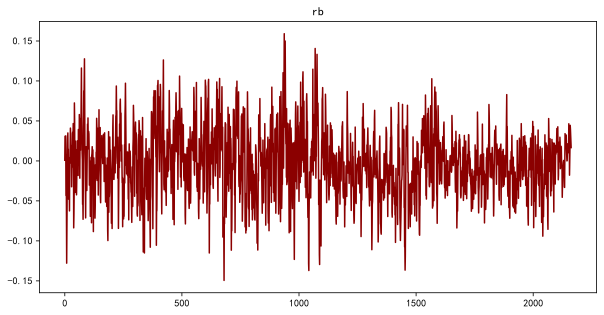

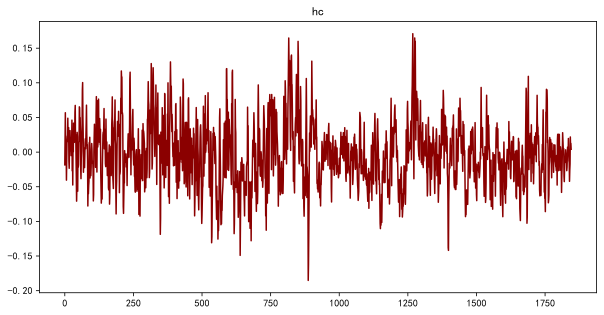

In [59]:
i = 0
period = 4096
for product in ["rb","hc"]:
    all_signal = get_all_5_signal(np.array(all_5_dates), product, "dbook.1."+str(period), period, HEAD_PATH, SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(10, 5))
    plt.title(product)
    plt.plot(all_signal, color="darkred")

In [60]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.04, 0.15, 0.002)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))

In [61]:
from collections import OrderedDict
def get_signal_5level_pnl(file, product, signal_name, thre_mat, reverse=1, tranct=1.1e-4, max_spread=0.61, tranct_ratio=True, 
                   HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH, atr_filter=0, rebate=0):
    ## load data
    data = load(HEAD_PATH+"\\pkl_level5\\"+product+"\\"+file)
    S = load(SIGNAL_PATH+"\\factor_pkl\\"+product+"\\"+signal_name+"\\"+file)
    pred = S*reverse
    data = data.reset_index(drop=True)
    pred = pred[data["good"]]
    #atr = load(SIGNAL_PATH+"\\factor_pkl\\"+product+"\\"+"atr.4096"+"\\"+file).reset_index(drop=True)
    #atr = atr[data["good"]].reset_index(drop=True)
    data = data[data["good"]].reset_index(drop=True)
    data["next.bid"] = data["BidPrice1"]
    data["next.bid"][:-1] = data["BidPrice1"][1:]
    data["next.ask"] = data["AskPrice1"]
    data["next.ask"][:-1] = data["AskPrice1"][1:]
    
    ## load signal
    ## we don't know the signal is positive correlated or negative correlated  
    #n_thre = len(thre_mat)
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.pnl", 0), ("pnl", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)
    count = 0
    cur_spread = data["AskPrice1"]-data["BidPrice1"]
    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        # signal[atr<atr_filter]=0
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data.index)
        position_pos.iloc[0] = 0
        position_pos[(signal==1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 1
        position_pos[(pred< -scratch) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 0
        position_pos.ffill(inplace=True)
        pre_pos = position_pos.shift(1)
        notional_position_pos = pd.Series(data=0, index=data.index)
        notional_position_pos[position_pos==1] = 1
        notional_position_pos[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos[(notional_position_pos==1)] = 1/data["next.ask"][(notional_position_pos==1)]
        notional_position_pos.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data.index)
        position_neg.iloc[0] = 0
        position_neg[(signal==-1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = -1
        position_neg[(pred> scratch) & (data["next.ask"]>0) & (cur_spread<max_spread)] = 0
        position_neg.ffill(inplace=True)
        pre_neg = position_neg.shift(1)
        notional_position_neg = pd.Series(data=0, index=data.index)
        notional_position_neg[position_neg==-1] = -1
        notional_position_neg[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg[(notional_position_neg==-1)] = -1/data["next.bid"][(notional_position_neg==-1)]
        notional_position_neg.ffill(inplace=True)
        position = position_pos + position_neg
        notional_position = notional_position_pos+notional_position_neg
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-2:] = 0
        notional_position.iloc[0] = 0
        notional_position.iloc[-2:] = 0
        change_pos = position - position.shift(1)
        notional_change_pos = notional_position-notional_position.shift(1)
        change_pos.iloc[0] = 0
        notional_change_pos.iloc[0] = 0
        change_base = pd.Series(data=0, index=data.index)
        change_buy = change_pos>0
        change_sell = change_pos<0
        if (tranct_ratio):
            change_base[change_buy] = data["next.ask"][change_buy]*(1+tranct)
            change_base[change_sell] = data["next.bid"][change_sell]*(1-tranct)
        else:
            change_base[change_buy] = data["next.ask"][change_buy]+tranct
            change_base[change_sell] = data["next.bid"][change_sell]-tranct
        final_pnl = -sum(change_base*change_pos)
        ret = -sum(change_base*notional_change_pos)
        num = sum((position!=0) & (change_pos!=0))
        if num == 0:
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (0,0,0,0,0)
            return result
        else:
            avg_pnl = np.divide(final_pnl, num)
            avg_ret = np.divide(ret,num)
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (num, avg_pnl, final_pnl, avg_ret,ret)
    return result


In [62]:
%%time
signal_name = "dbook.1."+str(period)
all_trade_stat = dict([])
n_days = len(all_5_dates)
for product in ["rb","hc"]:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_5level_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                  atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in all_5_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat, n_days)
    all_trade_stat[product] = trade_stat

Wall time: 4min


In [63]:
## save backtest result
save(all_trade_stat, SAVE_PATH+"\\processed_data\\"+"black_trade_stat_"+signal_name+".pkl")

In [64]:
signal_name = "dbook.1."+str(period)
all_trade_stat = load(SAVE_PATH+"\\processed_data\\"+"black_trade_stat_"+signal_name+".pkl")
date_str = [n[0:8] for n in all_5_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

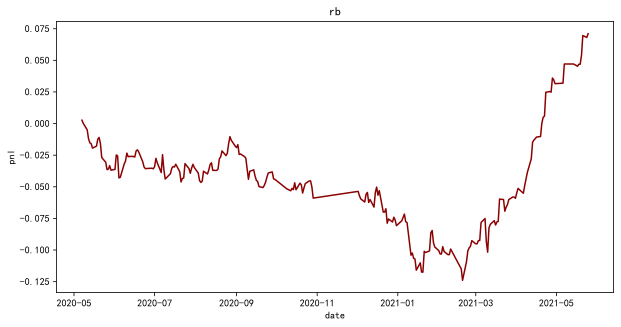

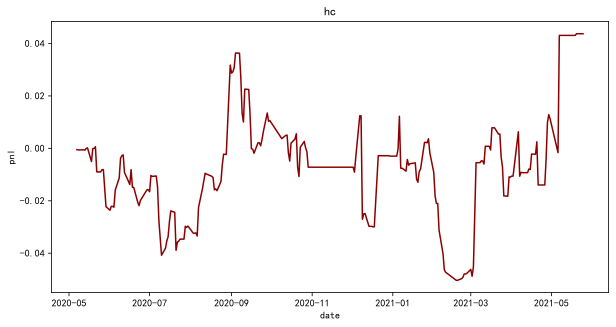

In [65]:
i = 0
for product in ["rb","hc"]:
    spread = product_info[product]["spread"]
    trade_stat = all_trade_stat[product]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    good_strat = trade_stat["final.result"]["avg.pnl"]>1*spread
    if sum(good_strat)>1:
        good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        i = i+1
        plt.figure(i, figsize=(10, 5))
        plt.title("")
        plt.xlabel("date")
        plt.ylabel("pnl")
        plt.title(product)
        plt.plot(format_dates, good_pnl.cumsum(), color="darkred")

In [66]:
%%time
for i in [2,3,4,5]:
    signal_name = "dbook."+str(i)+"."+str(period)
    all_trade_stat = dict([])
    for product in ["rb","hc"]:
        spread = product_info[product]["spread"]
        tranct = product_info[product]["tranct"]
        tranct_ratio = product_info[product]["tranct.ratio"]
        with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
            f_par = functools.partial(get_signal_5level_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                     reverse=-1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, 
                                      HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                      atr_filter=0.01)
            result = compute([delayed(f_par)(file) for file in all_5_dates])[0]
        trade_stat = get_hft_summary(result, thre_mat, n_days)
        all_trade_stat[product] = trade_stat
    save(all_trade_stat, SAVE_PATH+"\\processed_data\\"+"black_trade_stat_"+signal_name+".pkl")    


Wall time: 3min 4s


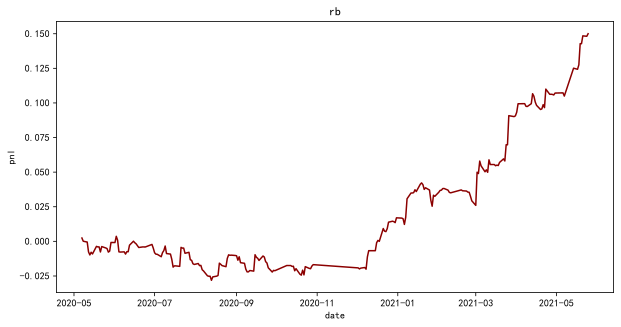

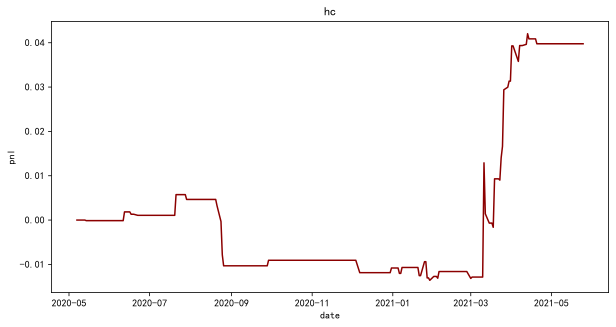

In [67]:
signal_name = "dbook.2."+str(period)
all_trade_stat = load(SAVE_PATH+"\\processed_data\\"+"black_trade_stat_"+signal_name+".pkl")
i = 0
for product in ["rb","hc"]:
    spread = product_info[product]["spread"]
    trade_stat = all_trade_stat[product]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    good_strat = trade_stat["final.result"]["avg.pnl"]>2*spread
    if sum(good_strat)>1:
        good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        i = i+1
        plt.figure(i, figsize=(10, 5))
        plt.title("")
        plt.xlabel("date")
        plt.ylabel("pnl")
        plt.title(product)
        plt.plot(format_dates, good_pnl.cumsum(), color="darkred")

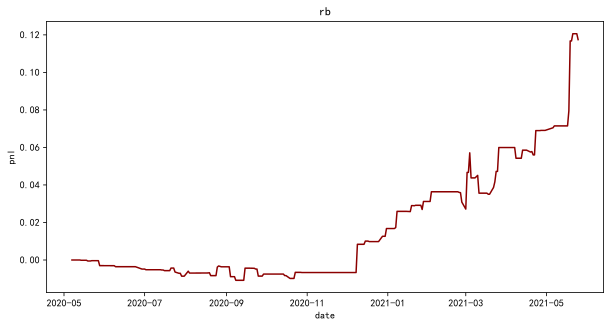

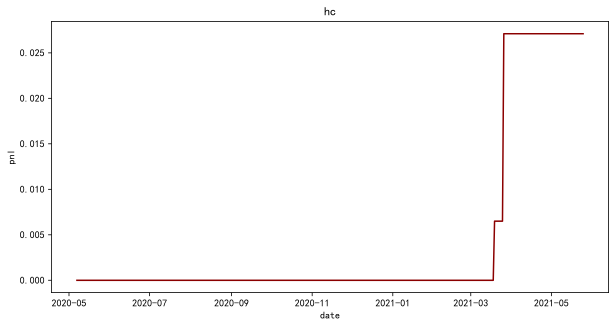

In [68]:
signal_name = "dbook.3."+str(period)
all_trade_stat = load(SAVE_PATH+"\\processed_data\\"+"black_trade_stat_"+signal_name+".pkl")
i = 0
for product in ["rb","hc"]:
    spread = product_info[product]["spread"]
    trade_stat = all_trade_stat[product]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    good_strat = trade_stat["final.result"]["avg.pnl"]>2*spread
    if sum(good_strat)>1:
        good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        i = i+1
        plt.figure(i, figsize=(10, 5))
        plt.title("")
        plt.xlabel("date")
        plt.ylabel("pnl")
        plt.title(product)
        plt.plot(format_dates, good_pnl.cumsum(), color="darkred")

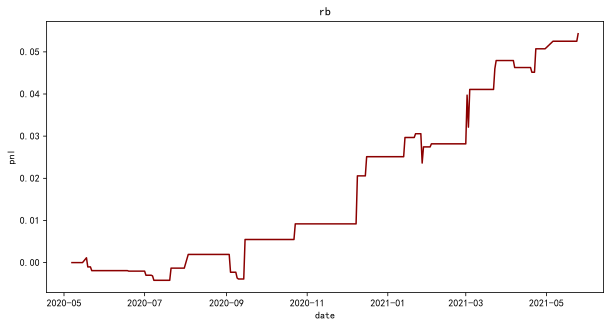

In [69]:
signal_name = "dbook.4."+str(period)
all_trade_stat = load(SAVE_PATH+"\\processed_data\\"+"black_trade_stat_"+signal_name+".pkl")
i = 0
for product in ["rb","hc"]:
    spread = product_info[product]["spread"]
    trade_stat = all_trade_stat[product]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    good_strat = trade_stat["final.result"]["avg.pnl"]>2*spread
    if sum(good_strat)>1:
        good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        i = i+1
        plt.figure(i, figsize=(10, 5))
        plt.title("")
        plt.xlabel("date")
        plt.ylabel("pnl")
        plt.title(product)
        plt.plot(format_dates, good_pnl.cumsum(), color="darkred")

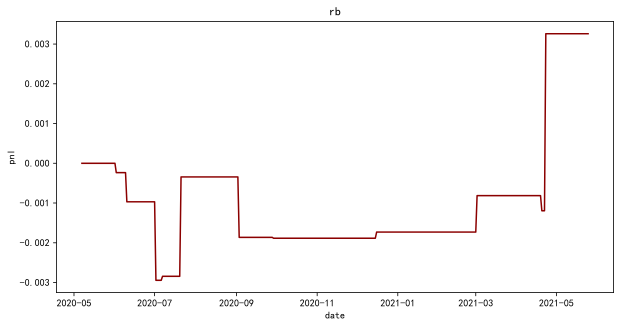

In [70]:
signal_name = "dbook.5."+str(period)
all_trade_stat = load(SAVE_PATH+"\\processed_data\\"+"black_trade_stat_"+signal_name+".pkl")
i = 0
for product in ["rb","hc"]:
    spread = product_info[product]["spread"]
    trade_stat = all_trade_stat[product]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    good_strat = trade_stat["final.result"]["avg.pnl"]>2*spread
    if sum(good_strat)>1:
        good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        i = i+1
        plt.figure(i, figsize=(10, 5))
        plt.title("")
        plt.xlabel("date")
        plt.ylabel("pnl")
        plt.title(product)
        plt.plot(format_dates, good_pnl.cumsum(), color="darkred")

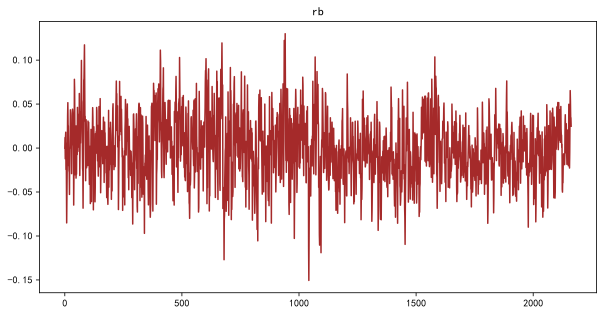

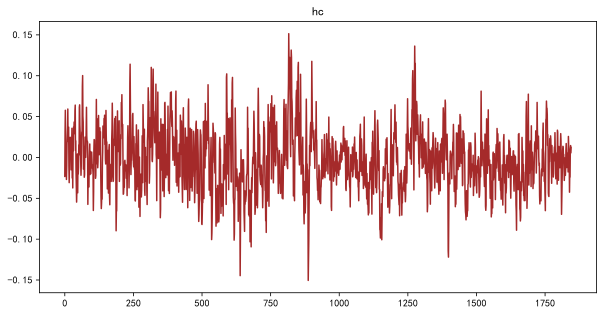

In [71]:
i = 0
for product in ["rb","hc"]:
    all_signal = get_all_5_signal(np.array(all_5_dates), product, "dbook.all."+str(period), period, HEAD_PATH, SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(10, 5))
    plt.title(product)
    plt.plot(all_signal, color="brown")

In [72]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.05, 0.15, 0.005)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))

In [73]:
%%time
signal_name = "dbook.all."+str(period)
all_trade_stat = dict([])
for product in ["rb","hc"]:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_5level_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                  atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in all_5_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat, n_days)
    all_trade_stat[product] = trade_stat


Wall time: 1min 20s


In [74]:
save(all_trade_stat, SAVE_PATH+"\\processed_data\\"+"black_trade_stat_"+signal_name+".pkl")  

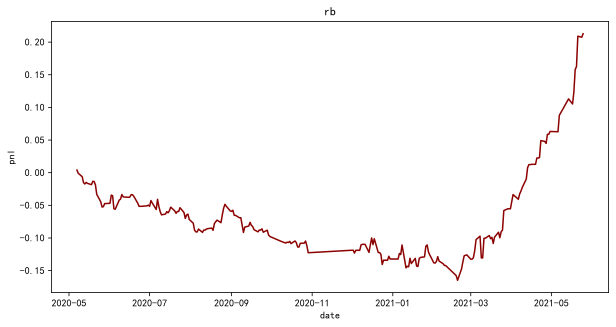

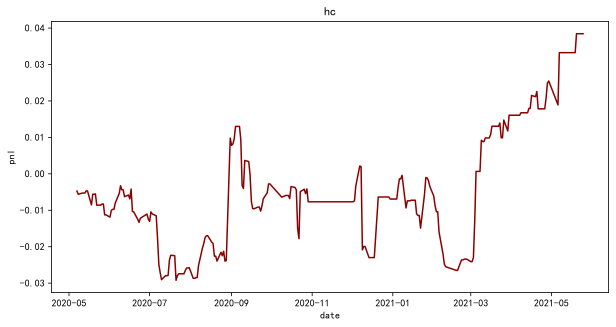

In [75]:
signal_name = "dbook.all."+str(period)
all_trade_stat = load(SAVE_PATH+"\\processed_data\\"+"black_trade_stat_"+signal_name+".pkl")
i = 0
for product in ["rb","hc"]:
    spread = product_info[product]["spread"]
    trade_stat = all_trade_stat[product]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    good_strat = trade_stat["final.result"]["avg.pnl"]>2*spread
    if sum(good_strat)>1:
        good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        i = i+1
        plt.figure(i, figsize=(10, 5))
        plt.title("")
        plt.xlabel("date")
        plt.ylabel("pnl")
        plt.title(product)
        plt.plot(format_dates, good_pnl.cumsum(), color="darkred")

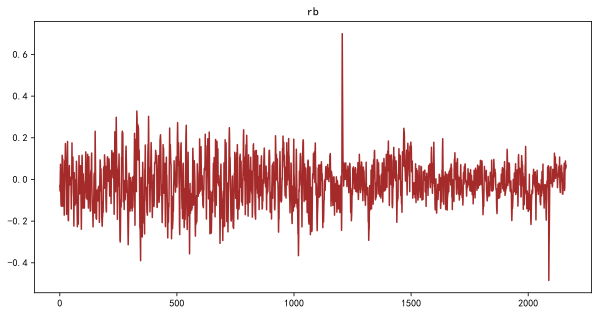

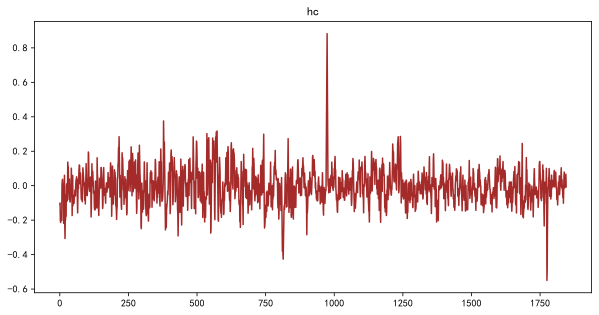

In [76]:
i = 0
for product in ["rb","hc"]:
    all_signal = get_all_5_signal(np.array(all_5_dates), product, "imb.all."+str(period), period, HEAD_PATH, SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(10, 5))
    plt.title(product)
    plt.plot(all_signal, color="brown")

In [77]:
%%time
signal_name = "imb.all."+str(period)
all_trade_stat = dict([])
for product in ["rb","hc"]:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_5level_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                  atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in all_5_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat, n_days)
    all_trade_stat[product] = trade_stat

Wall time: 3min 13s


In [78]:
save(all_trade_stat, SAVE_PATH+"\\processed_data\\"+"black_imb_stat_"+signal_name+".pkl")  

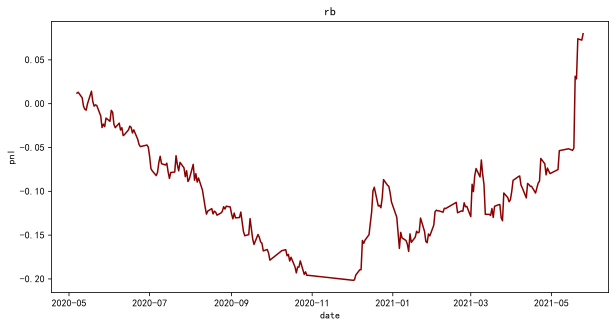

In [79]:
signal_name = "imb.all."+str(period)
all_trade_stat = load(SAVE_PATH+"\\processed_data\\"+"black_imb_stat_"+signal_name+".pkl")
i = 0
for product in ["rb","hc"]:
    spread = product_info[product]["spread"]
    trade_stat = all_trade_stat[product]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    good_strat = trade_stat["final.result"]["avg.pnl"]>1*spread
    if sum(good_strat)>1:
        good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        i = i+1
        plt.figure(i, figsize=(10, 5))
        plt.title("")
        plt.xlabel("date")
        plt.ylabel("pnl")
        plt.title(product)
        plt.plot(format_dates, good_pnl.cumsum(), color="darkred")